In [303]:
# !pip install xgboost

In [323]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

In [262]:
raw_df_train = pd.read_csv('data/rosbank_train.csv')
raw_df_test = pd.read_csv('data/rosbank_test.csv')
raw_df = pd.concat([raw_df_train, raw_df_test], axis=0, sort=False)

raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0,0.0


In [287]:
raw_df.tail()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,day_of_transaction,hour_of_transaction
518371,01/04/2017,10135,5074,type1,810,17APR17:00:00:00,6133.6,POS,NaN,NaN,1,00
518372,01/03/2017,10135,5912,type1,810,10MAR17:00:00:00,394.5,POS,NaN,NaN,5,00
518373,01/05/2017,10135,5541,type1,810,01MAY17:00:00:00,1813.5,POS,NaN,NaN,1,00
518374,01/03/2017,10135,5912,type1,810,16MAR17:00:00:00,569.3,POS,NaN,NaN,4,00
518375,01/03/2017,10135,5411,type1,810,18MAR17:00:00:00,298.0,POS,NaN,NaN,6,00


In [265]:
# raw_train.info()

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

In [266]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

### Категориальный признак trx_category

In [267]:
raw_df.trx_category.value_counts()

POS               858574
DEPOSIT            43086
WD_ATM_ROS         38414
WD_ATM_PARTNER     20428
C2C_IN             15196
WD_ATM_OTHER       14117
C2C_OUT            11210
BACK_TRX            5433
CAT                 2358
CASH_ADV              73
Name: trx_category, dtype: int64

In [268]:
# # общая сумма транзакций по каждой из trx_category
# raw_trx_category = raw_df.groupby(['cl_id','trx_category',], as_index=False).agg({"amount": ["count"]})
# raw_trx_category.columns = ['cl_id','trx_category', 'count']
# raw_trx_category = raw_trx_category.pivot(index='cl_id', columns='trx_category', values='count').fillna(0)

In [269]:
raw_trx_category = get_aggregated_df(raw_df, 'count', 'trx_category')

In [270]:
raw_trx_category.head()

trx_category,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS
cl_id,,,,,,,,,,
0,0,0,1,0,0,1,3,0,0,0
1,0,0,0,0,0,2,101,0,0,1
2,2,1,1,0,0,0,175,0,11,9
3,0,2,2,0,0,0,78,4,0,10
4,0,0,2,0,0,0,146,0,6,4


### Категориальный признак currency

In [271]:
raw_df.currency.value_counts().head()
# raw_df.currency.value_counts().head(4).keys()

810    981731
978     11573
840      3808
933      1460
764       941
Name: currency, dtype: int64

In [272]:
# общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)¶
top_curr = raw_df.currency.value_counts().head(3).keys()
temp_raw = raw_df.copy()
temp_raw.loc[~temp_raw.currency.isin(top_curr) , 'currency'] = 'other' # можно сделать функцию
# raw_currency = temp_raw.groupby(['cl_id','currency',], as_index=False).agg({"amount": ["count"]})
# raw_currency.columns = ['cl_id','currency', 'count']
# raw_currency = raw_currency.pivot(index='cl_id', columns='currency', values='count').fillna(0)


In [273]:
raw_currency = get_aggregated_df(temp_raw, 'count', 'currency')

In [274]:
raw_currency.head()

currency,currency_count_810,currency_count_840,currency_count_978,currency_count_other
cl_id,,,,
0,5,0,0,0
1,70,0,34,0
2,199,0,0,0
3,90,0,0,6
4,154,0,4,0


### Категориальный признак MCC

In [275]:
# общая сумма транзакций по категориям MCC кодов

In [276]:
raw_MCC1 =raw_df.groupby(['MCC'], as_index=False).agg({"amount": "count"})
raw_MCC1.columns = ['MCC', 'amount_count']
temp_raw_MCC = raw_MCC1.sort_values(by='amount_count', ascending=False).head(10)
top_MCC = temp_raw_MCC.MCC.values
top_MCC

array([5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921])

In [277]:
temp_raw = raw_df.copy()
temp_raw.loc[~temp_raw.MCC.isin(top_MCC) , 'MCC'] = 'MCC_other' # можно сделать функцию

In [278]:
# raw_MCC =temp_raw.groupby(['cl_id','MCC'], as_index=False).agg({"amount": "count"})
# raw_MCC.columns = ['cl_id','MCC', 'amount_count']
# raw_MCC= raw_MCC.pivot(index='cl_id', columns='MCC', values='amount_count').fillna(0)


In [279]:
raw_MCC = get_aggregated_df(temp_raw, 'count', 'MCC')

In [280]:
raw_MCC.head()

MCC,MCC_count_5411,MCC_count_5499,MCC_count_5541,MCC_count_5812,MCC_count_5814,MCC_count_5912,MCC_count_5921,MCC_count_5999,MCC_count_6011,MCC_count_6012,MCC_count_MCC_other
cl_id,,,,,,,,,,,
0,1,0,0,0,0,0,1,0,1,1,1
1,12,2,0,19,41,3,0,1,3,0,23
2,8,0,1,34,57,4,0,1,21,0,73
3,12,1,0,7,22,5,1,8,14,3,23
4,21,2,3,12,33,3,10,10,10,2,52


 ### возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

In [281]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0)#.reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

In [282]:
raw_transaction_by_day=transaction_by_day_count(raw_df)
raw_transaction_by_day.head()

day_of_transaction,day_0,day_1,day_2,day_3,day_4,day_5,day_6
cl_id,,,,,,,
0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,8.0,32.0,41.0,29.0,37.0,37.0,15.0
3,8.0,17.0,14.0,16.0,17.0,15.0,9.0
4,22.0,17.0,8.0,12.0,22.0,28.0,49.0


In [283]:
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0)#.reset_index()

In [284]:
raw_transaction_by_hour = transaction_by_hour_count(raw_df)
raw_transaction_by_hour.head()

hour_of_transaction,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
cl_id,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,188.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0
4,144.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Объединение данных

In [316]:
X = raw_df[['cl_id', 'channel_type', 'target_flag']].drop_duplicates().set_index('cl_id')
col_list = ['channel_type']
X = get_one_hot(X, col_list).drop('channel_type', axis = 1)
X = X.join(raw_trx_category).join(raw_currency)
X = X.join(raw_MCC)
X = X.join(raw_transaction_by_day)
X = X.join(raw_transaction_by_hour)

In [317]:
X.head()

,target_flag,channel_type_type0,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,...,14,15,16,17,18,19,20,21,22,23
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,1,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
5,1.0,1,0,0,0,0,0,1,0,8,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
9,0.0,1,0,0,0,0,0,0,3,0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
10,0.0,1,0,0,0,0,0,0,1,19,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [318]:
x_train = X.loc[~X.target_flag.isna()].drop('target_flag', axis = 1)
x_test = X.loc[X.target_flag.isna()].drop('target_flag', axis = 1)
y_train = X.loc[~X.target_flag.isna(), 'target_flag']

In [319]:
x_test.head()

,channel_type_type0,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,...,14,15,16,17,18,19,20,21,22,23
cl_id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,2,1,1,0,...,3.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1,0,0,0,0,0,0,2,2,0,...,4.0,2.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0
4,1,0,0,0,0,0,0,0,2,0,...,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1,0,0,0,0,0,0,2,6,0,...,2.0,2.0,4.0,5.0,2.0,6.0,2.0,0.0,0.0,0.0
7,1,0,0,0,0,0,1,0,1,0,...,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [325]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
# roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
# print("Test: ", roc_auc_test)

Train:  0.92


### Категориальный признак channel_type

In [288]:
#Замена NaN на type0
raw_df.loc[raw_df.channel_type.isna(), 'channel_type'] = 'type0'

Text(0.5, 1.0, 'Кол-во транзакций по channel_type')

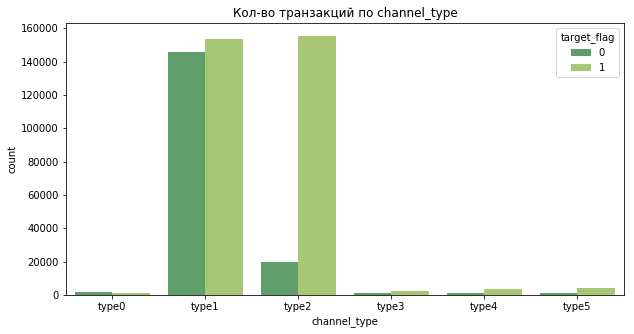

In [136]:
raw_channel_type = raw_df.groupby(['channel_type','target_flag'], as_index=False).agg({"amount": ["count"]})
raw_channel_type.columns = ['channel_type', 'target_flag', 'count']
plt.figure(figsize=(10,5))
sns.barplot(x='channel_type',y='count', hue= 'target_flag', data=raw_channel_type, palette='summer')
plt.title('Кол-во транзакций по channel_type')
# выбивается type2

In [158]:
# raw_channel_2 = raw_df.groupby(['cl_id'], as_index=False).channel_type
# raw_channel_2.columns = ['cl_id','channel_type']
# # raw_channel_2.head()

# col_list = ['channel_type']
# one_hot_df = get_one_hot(raw_channel_2, col_list)
# one_hot_df.head()

In [161]:
# raw_df.get(['cl_id', 'channel_type']).groupby(['cl_id'], as_index=False)

### провести первичный анализ данных - посмотреть распределения признаков

In [142]:
# sns.pairplot(raw_df)

### Общая картина, самые популярные MCC и самые валидные:

In [126]:
# raw_MCC =raw_df.groupby(['MCC','target_flag'], as_index=False).agg({"amount": ["sum","count"]})
# raw_MCC.columns = ['MCC', 'target_flag', 'amount_sum', 'amount_count']
# # raw_MCC.head(10)

In [125]:
# all_count_amount=raw_MCC.amount_count.sum()
# all_sum_amount=raw_MCC.amount_sum.sum()
# raw_MCC.amount_sum = raw_MCC.amount_sum/all_sum_amount*100
# raw_MCC.amount_count = raw_MCC.amount_count/all_count_amount*100
# df_14_count = raw_MCC.sort_values(by='amount_count', ascending=False).head(14)
# df_14_sum = raw_MCC.sort_values(by='amount_sum', ascending=False).head(14)

In [124]:
# plt.figure(figsize=(10,5))
# sns.barplot(x='MCC',y='amount_count', hue= 'target_flag', data=df_14_count, palette='summer')
# plt.title('Топ процент кол-ва транзакций по МСС в разрезе таргета')

In [123]:
# plt.figure(figsize=(10,5))
# sns.barplot(x='MCC',y='amount_sum', hue= 'target_flag', data=df_14_sum, palette='summer')
# plt.title('Топ процент сумм клиентов по МСС в разрезе таргета')

### Категориальный признак channel_type

In [96]:
# raw_df.channel_type.value_counts()

In [97]:
# #Замена NaN на type0
# raw_df.loc[raw_df.channel_type.isna(), 'channel_type'] = 'type0'

In [127]:
# raw_channel_type = raw_df.groupby(['channel_type','target_flag'], as_index=False).agg({"amount": ["count"]})
# raw_channel_type.columns = ['channel_type', 'target_flag', 'count']
# plt.figure(figsize=(10,5))
# sns.barplot(x='channel_type',y='count', hue= 'target_flag', data=raw_channel_type, palette='summer')
# plt.title('Кол-во транзакций по channel_type')
# # выбивается type2

### Категориальный признак trx_category

In [128]:
# raw_df.trx_category.value_counts()

In [129]:
# raw_trx_category = raw_df.groupby(['trx_category','target_flag'], as_index=False).agg({"amount": ["count"]})
# raw_trx_category.columns = ['trx_category', 'target_flag', 'count']
# plt.figure(figsize=(20,5))
# sns.barplot(x='trx_category',y='count', hue= 'target_flag', data=raw_trx_category, palette='summer')
# plt.title('Кол-во транзакций по trx_category')
# # выбивается type2

In [307]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [326]:
# col_list = ['channel_type', 'trx_category']
# one_hot_df = get_one_hot(raw_df, col_list)
# one_hot_df.head()